In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from edu.javerianacali.create_dataset import CreateDataSet
from edu.javerianacali.model.ccn_model import ConvulationalNeuralNetwork
from edu.javerianacali.model.logistic_regression_model import LogisticRegressionModel
from edu.javerianacali.process_images import ProcessImages
from edu.javerianacali.data_aumentation import DataAugmentation
from edu.javerianacali.model.svm_model import SupportVectorMachineModel
directorio = "/data/maestria/maestriasinpro/proyectodegrado/pujc-advocato-filter-project-mngr/assets"


2024-05-31 15:10:09.885143: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 15:10:09.887816: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 15:10:09.921048: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 15:10:10.615036: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# AUMENTO DE DATOS

In [ ]:

from edu.javerianacali.data_aumentation import DataAugmentation

DataAugmentation().augment_images(directorio+'/poquitas'

)

# PROCESAR INAGENES PARA MODELOS DE APRENDIZAJE SUPERVISADO

In [ ]:
path=directorio+'/poquitas'
archivos = os.listdir(path)
for archivo in archivos:
    if archivo.endswith((".jpg", ".JPG", ".jpeg", ".png")):
        ruta_imagen = os.path.join(path, archivo)
        titulos = ["Ori", "SinTex","Sinsomb", archivo]
        imagenes = ProcessImages().procesar_imagen(ruta_imagen,archivo,directorio,200,200)
        ProcessImages().mostrar_imagenes(titulos, imagenes)



# RED NEURONAL

In [ ]:
path=directorio
archivos = os.listdir(path)
for archivo in archivos:
    if archivo.endswith((".jpg", ".JPG", ".jpeg", ".png")):
        ruta_imagen = os.path.join(path, archivo)
        titulos = ["Ori", "SinTex","Sinsomb", archivo]
        imagenes = ProcessImages().procesar_imagen(ruta_imagen,archivo,directorio,200,200)
       # ProcessImages().mostrar_imagenes(titulos, imagenes)



In [ ]:

CreateDataSet().create_dataset_cnn(directorio)

In [2]:
from tensorflow.keras.utils import to_categorical

from sklearn.utils.class_weight import compute_class_weight
train_dir = directorio+'/train'  # Ajusta esta ruta
val_dir = directorio+'/test'  # Ajusta esta ruta

# Cargar datos
X_train, y_train, class_names_train = CreateDataSet().load_images_from_directory(train_dir)
X_val, y_val, class_names_val = CreateDataSet().load_images_from_directory(val_dir)

# Normalizar las imágenes
X_train = X_train / 255.0
X_val = X_val / 255.0

# Convertir las etiquetas a categóricas
y_train = to_categorical(y_train, num_classes=len(class_names_train))
y_val = to_categorical(y_val, num_classes=len(class_names_val))

class_weights = compute_class_weight('balanced', classes=np.unique(y_train.argmax(axis=1)), y=y_train.argmax(axis=1))
class_weights = dict(enumerate(class_weights))



In [3]:
import tensorflow as tf
from keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

input_shape = (200, 200, 3)
input_tensor = Input(shape=input_shape)

modelo = Sequential([
   Conv2D(64, (3,3), activation='relu', padding="same", input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(128, (3,3), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(256, (3,3), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(512, (3,3), activation='relu', padding="same"),  # Capa adicional
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(512, (3,3), activation='relu', padding="same"),  # Capa adicional
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dropout(0.5),  # Capa de abandono para regularización
    Dense(256, activation='relu'),  # Aumentar el número de nodos
    Dense(len(class_names_train), activation='softmax'),
 ])


modelo.summary()

learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)
modelo.compile(optimizer=optimizer , # Ajustar la tasa de aprendizaje
    loss='binary_crossentropy',  
    metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

historial = modelo.fit(
        X_train, y_train,
    epochs=50,  # Aumentar el número de épocas,
    batch_size=64,
      validation_data=(X_val, y_val),callbacks=[early_stopping, reduce_lr]

)



/home/maucasco/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,630,146 (32.92 MB)

 Trainable params: 8,630,146 (32.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 60s 5s/step - accuracy: 0.4708 - loss: 368.0716 - val_accuracy: 0.4540 - val_loss: 1.4919 - learning_rate: 0.0100
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 66s 5s/step - accuracy: 0.7766 - loss: 0.6037 - val_accuracy: 0.9288 - val_loss: 0.2848 - learning_rate: 0.0100
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 69s 5s/step - accuracy: 0.9081 - loss: 0.2662 - val_accuracy: 0.9228 - val_loss: 0.2292 - learning_rate: 0.0100
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 71s 6s/step - accuracy: 0.9005 - loss: 0.3110 - val_accuracy: 0.9228 - val_loss: 0.3026 - learning_rate: 0.0100
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 74s 6s/step - accuracy: 0.9091 - loss: 0.2866 - val_accuracy: 0.9228 - val_loss: 0.2282 - learning_rate: 0.0100
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 75s 6s/step - accuracy: 0.9071 - loss: 0.2517 - val_accuracy: 0.9347 - val_loss: 0.2072 - learning_rate: 0.0100
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 74s 6s/step - accuracy: 0.9146 - loss: 0.2185 - val_accuracy

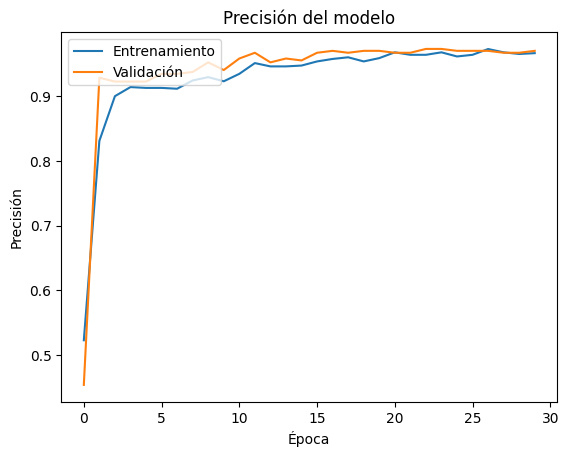

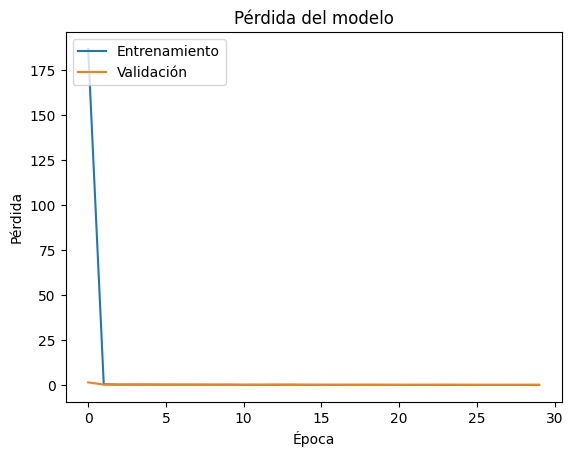

In [4]:

# Gráficos de precisión y pérdida
plt.plot(historial.history['accuracy'])
plt.plot(historial.history['val_accuracy'])  # Precisión de validación
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

plt.plot(historial.history['loss'])
plt.plot(historial.history['val_loss'])  # Pérdida de validación
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')# Añade la capa Dense según el tamaño de salida de Flatten


plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(modelo, to_file='/data/maestria/maestriasinpro/proyectodegrado/pujc-advocato-filter-project-mngr/modelo1_cnn.png', show_shapes=True, show_layer_names=True)

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 532ms/step
Matriz de Confusión


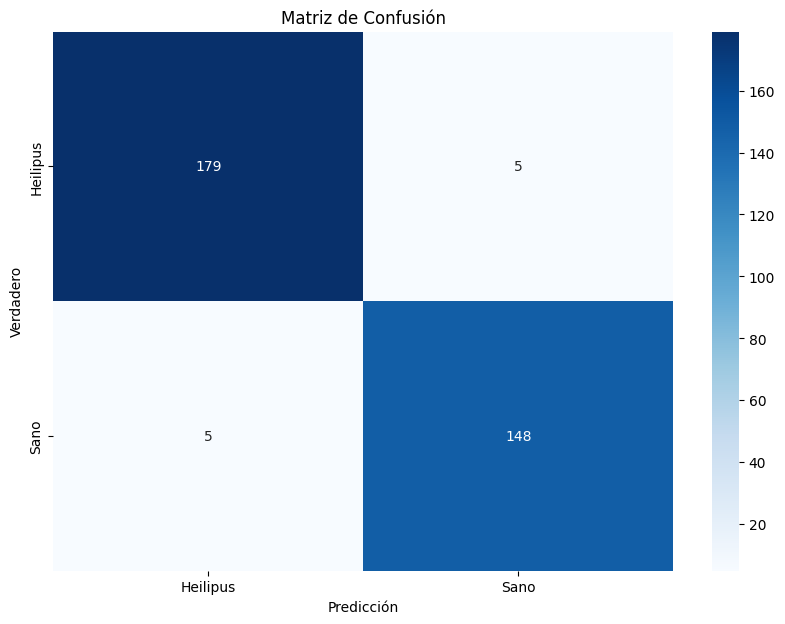

Informe de Clasificación
{'0': {'precision': 0.9728260869565217, 'recall': 0.9728260869565217, 'f1-score': 0.9728260869565217, 'support': 184.0}, '1': {'precision': 0.9673202614379085, 'recall': 0.9673202614379085, 'f1-score': 0.9673202614379085, 'support': 153.0}, 'accuracy': 0.9703264094955489, 'macro avg': {'precision': 0.9700731741972151, 'recall': 0.9700731741972151, 'f1-score': 0.9700731741972151, 'support': 337.0}, 'weighted avg': {'precision': 0.9703264094955489, 'recall': 0.9703264094955489, 'f1-score': 0.9703264094955489, 'support': 337.0}}


,precision,recall,f1-score,support
0,0.972826,0.972826,0.972826,184.000000
1,0.967320,0.967320,0.967320,153.000000
accuracy,0.970326,0.970326,0.970326,0.970326
macro avg,0.970073,0.970073,0.970073,337.000000
weighted avg,0.970326,0.970326,0.970326,337.000000


In [5]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
# Evaluar el modelo en el conjunto de prueba o validación
# Asumiendo que tienes `validation_generator` como tu conjunto de validación/test
# Realizar predicciones en el conjunto de validación
y_pred = modelo.predict(X_val)
y_test = np.argmax(y_val, axis=1)  # Etiquetas verdaderas
y_pred = np.argmax(y_pred, axis=1)  # Convertir predicciones a etiquetas


# Matriz de confusión
print("Matriz de Confusión")
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)


# Visualización de la matriz de confusión
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names_val, yticklabels=class_names_val)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()


# Informe de clasificación

report = classification_report(y_test, y_pred, output_dict=True)
print("Informe de Clasificación")
print(report)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv('classification_report_cnn.csv', index=True)

cm = sns.light_palette("blue", as_cmap=True)
styled_df = report_df.style.background_gradient(cmap=cm)
display(styled_df)


In [ ]:
import keras
print(keras.__version__)

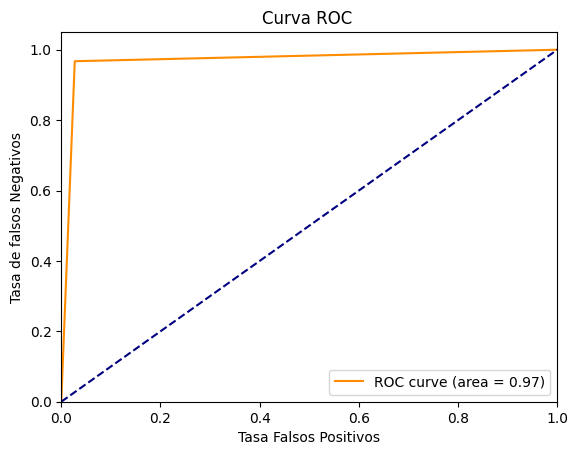

In [6]:
# Si y_pred es unidimensional, no necesitas indexarlo con [:, 1]
if y_pred.ndim == 1:
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Visualización de la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa Falsos Positivos')
    plt.ylabel('Tasa de falsos Negativos')
    plt.title('Curva ROC ')
    plt.legend(loc="lower right")
    plt.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
import cv2  # Asegúrate de tener OpenCV instalado para la redimensión de la imagen


# Seleccionar una imagen del conjunto de validación para visualizar las activaciones
image_to_visualize = X_val[2]

# Verificar las dimensiones de la imagen
print("Dimensiones de la imagen:", image_to_visualize.shape)

# Asegurarse de que la imagen tiene las dimensiones correctas (200, 200, 3)
if image_to_visualize.shape != (200, 200, 3):
    image_to_visualize = cv2.resize(image_to_visualize, (200, 200))

# Normalizar la imagen
image_to_visualize = image_to_visualize / 255.0

# Realizar una llamada al modelo para establecer sus dimensiones de entrada
_ = modelo.predict(image_to_visualize.reshape(1, 200, 200, 3))

# Crear un modelo que devuelva las activaciones de la capa deseada
layer_index = 0  # Cambia esto para visualizar otras capas
activation_model = Model(inputs=modelo.discriminator.inputs, outputs=modelo.layers[layer_index].output)

# Obtener las activaciones
activations = activation_model.predict(image_to_visualize.reshape(1, 200, 200, 3))

# Verificar las dimensiones de las activaciones
print("Dimensiones de las activaciones:", activations.shape)

# Visualizar las activaciones de los primeros 6 filtros
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    if i < activations.shape[-1]:  # Asegurarse de que el índice está dentro del rango de filtros disponibles
        ax.imshow(activations[0, :, :, i], cmap='viridis')
    ax.axis('off')
plt.show()


Dimensiones de la imagen: (200, 200, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


AttributeError: 'Sequential' object has no attribute 'discriminator'

In [ ]:
# Guardar el modelo en un archivo
modelo.save('/data/maestria/maestriasinpro/proyectodegrado/pujc-advocato-filter-project-mngr/modelo_cnn.h5')


In [9]:
model = tf.keras.models.load_model('modelo_cnn.h5')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

AttributeError: 'Sequential' object has no attribute '_get_save_spec'

In [ ]:
# Cargar el modelo desde un archivo
from keras.models import load_model
modelo = load_model('/data/maestria/maestriasinpro/proyectodegrado/pujc-advocato-filter-project-mngr/modelo_cnn.h5')

In [ ]:

from keras.preprocessing import image
import numpy as np
# Load and preprocess the image
img_path = '/home/maucasco/Downloads/images.jpeg'
imagen = cv2.imread(img_path)[100:, :]
imagen_sin_texto,aguacate_solo, redimenciada = ProcessImages().procesar(imagen,500,500)
img_array = image.img_to_array(redimenciada)


plt.imshow(redimenciada, cmap='gray')
plt.show()
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Make predictions
predictions = modelo.predict(img_array)
print(predictions)